<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Symmetric Noise 40%</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.4
loss_function = 'DampedSCELoss' 
dataset = 'aircrafts'
noise_type = 'sym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedSCELoss_aircrafts_sym_0.4_0.25_baseline
Model Features: DampedSCELoss_aircrafts_sym_0.4_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedSCELoss_aircrafts_sym_0.4_0.25
Csv save: DampedSCELoss_aircrafts_sym_0.4_0.25
Saving features from Scheme delta = 0.25: DampedSCELoss_aircrafts_sym_0.4_0.5
Saving csv for damp_2: DampedSCELoss_aircrafts_sym_0.4_0.5


# Declaration of Efficient Net family with Resolution, and Batch size

In [4]:
architecture = 'efficientnet-b4'

effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [5]:
import pandas as pd
train_df = pd.read_csv("aircrafts_sym_0.4.csv")
train_df

Filepath  Noisy_labels  Label  Label_numeric
0      aircrafts_original/0/0548719.jpg            53      0              0
1      aircrafts_original/0/1152266.jpg            93      0              0
2      aircrafts_original/0/0894380.jpg            22      0              0
3      aircrafts_original/0/0716386.jpg            90      0              0
4      aircrafts_original/0/0450014.jpg            85      0              0
...                                 ...           ...    ...            ...
6662  aircrafts_original/99/1227260.jpg            99     99             99
6663  aircrafts_original/99/1320583.jpg            99     99             99
6664  aircrafts_original/99/0792373.jpg            99     99             99
6665  aircrafts_original/99/1691701.jpg            99     99             99
6666  aircrafts_original/99/1117057.jpg            99     99             99

[6667 rows x 4 columns]

In [5]:
print(train_df.Noisy_labels.tolist())

[89, 79, 91, 18, 84, 56, 81, 23, 39, 20, 81, 85, 0, 30, 62, 13, 47, 53, 21, 84, 60, 39, 14, 93, 98, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 46, 53, 69, 56, 19, 5, 28, 86, 27, 21, 29, 87, 93, 72, 73, 34, 50, 1, 29, 82, 48, 28, 57, 36, 69, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 31, 3, 41, 12, 99, 71, 75, 69, 38, 2, 5, 82, 87, 78, 91, 34, 56, 44, 72, 62, 13, 17, 32, 89, 33, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 61, 3, 4, 62, 73, 74, 32, 45, 16, 79, 16, 1, 12, 8, 77, 8, 88, 13, 21, 97, 20, 13, 64, 54, 52, 90, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 44, 79, 85, 64, 65, 76, 4, 52, 57, 17, 57, 61, 89, 78, 90, 6, 59, 82, 53, 11, 25, 58, 16, 17, 29, 92, 4, 4

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

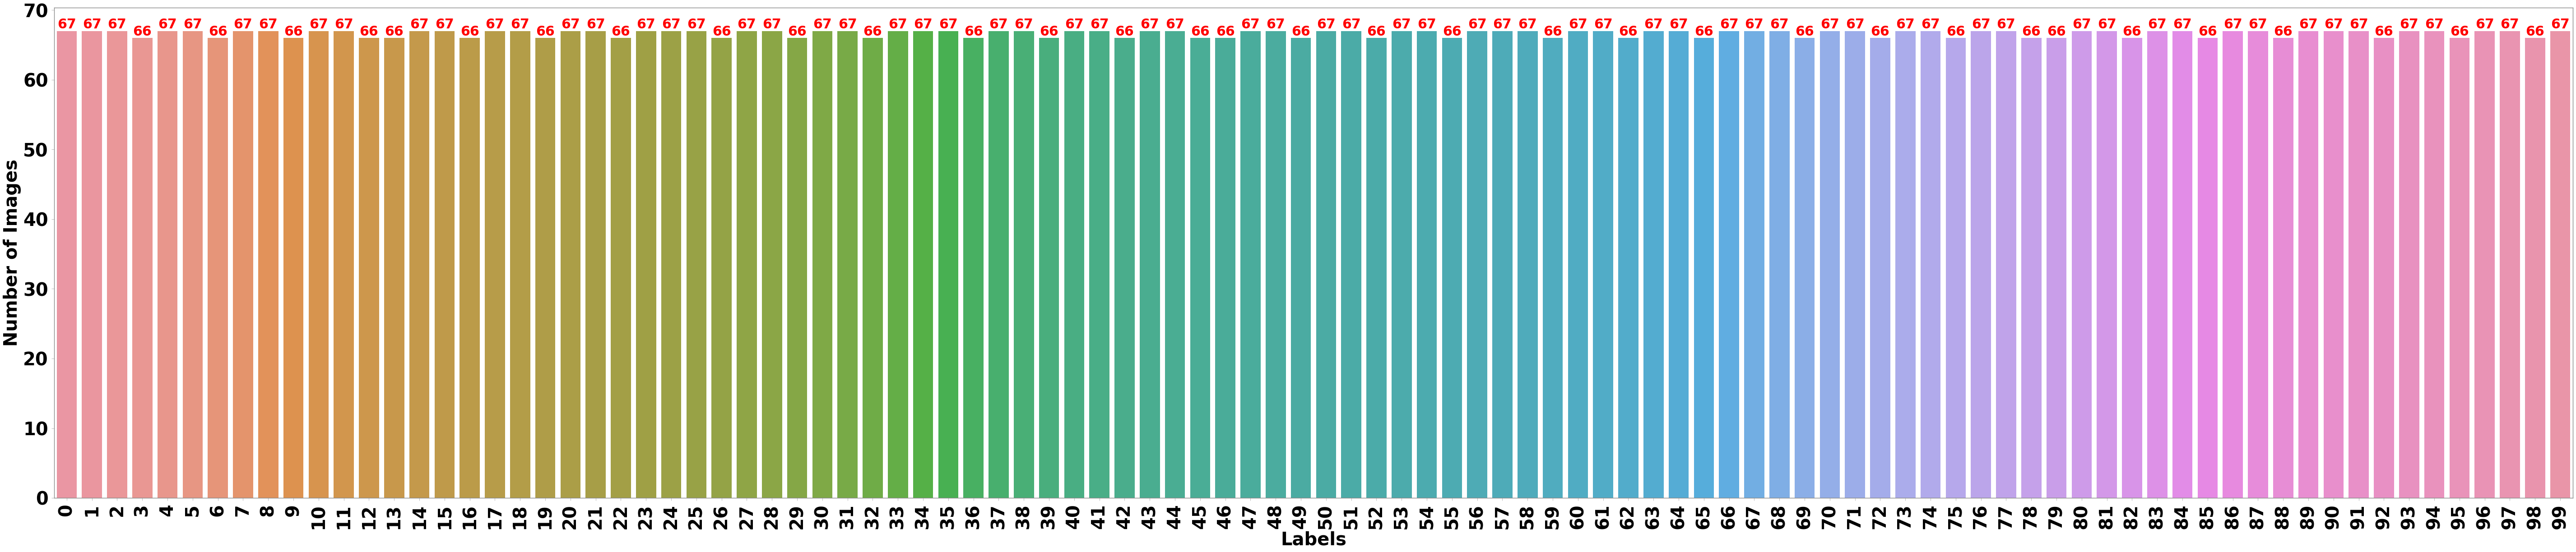

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Writing testing  Data into CSV  (Test data frame df)

In [8]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

Filepath Label
0     testing/32/1691545.jpg    32
1     testing/32/2212521.jpg    32
2     testing/32/1508910.jpg    32
3     testing/32/1260329.jpg    32
4     testing/32/0199985.jpg    32
...                      ...   ...
3328  testing/42/0773394.jpg    42
3329  testing/42/0875337.jpg    42
3330  testing/42/0759282.jpg    42
3331  testing/42/2228007.jpg    42
3332  testing/42/2110996.jpg    42

[3333 rows x 2 columns]

Text(0, 0.5, 'Number of Images')

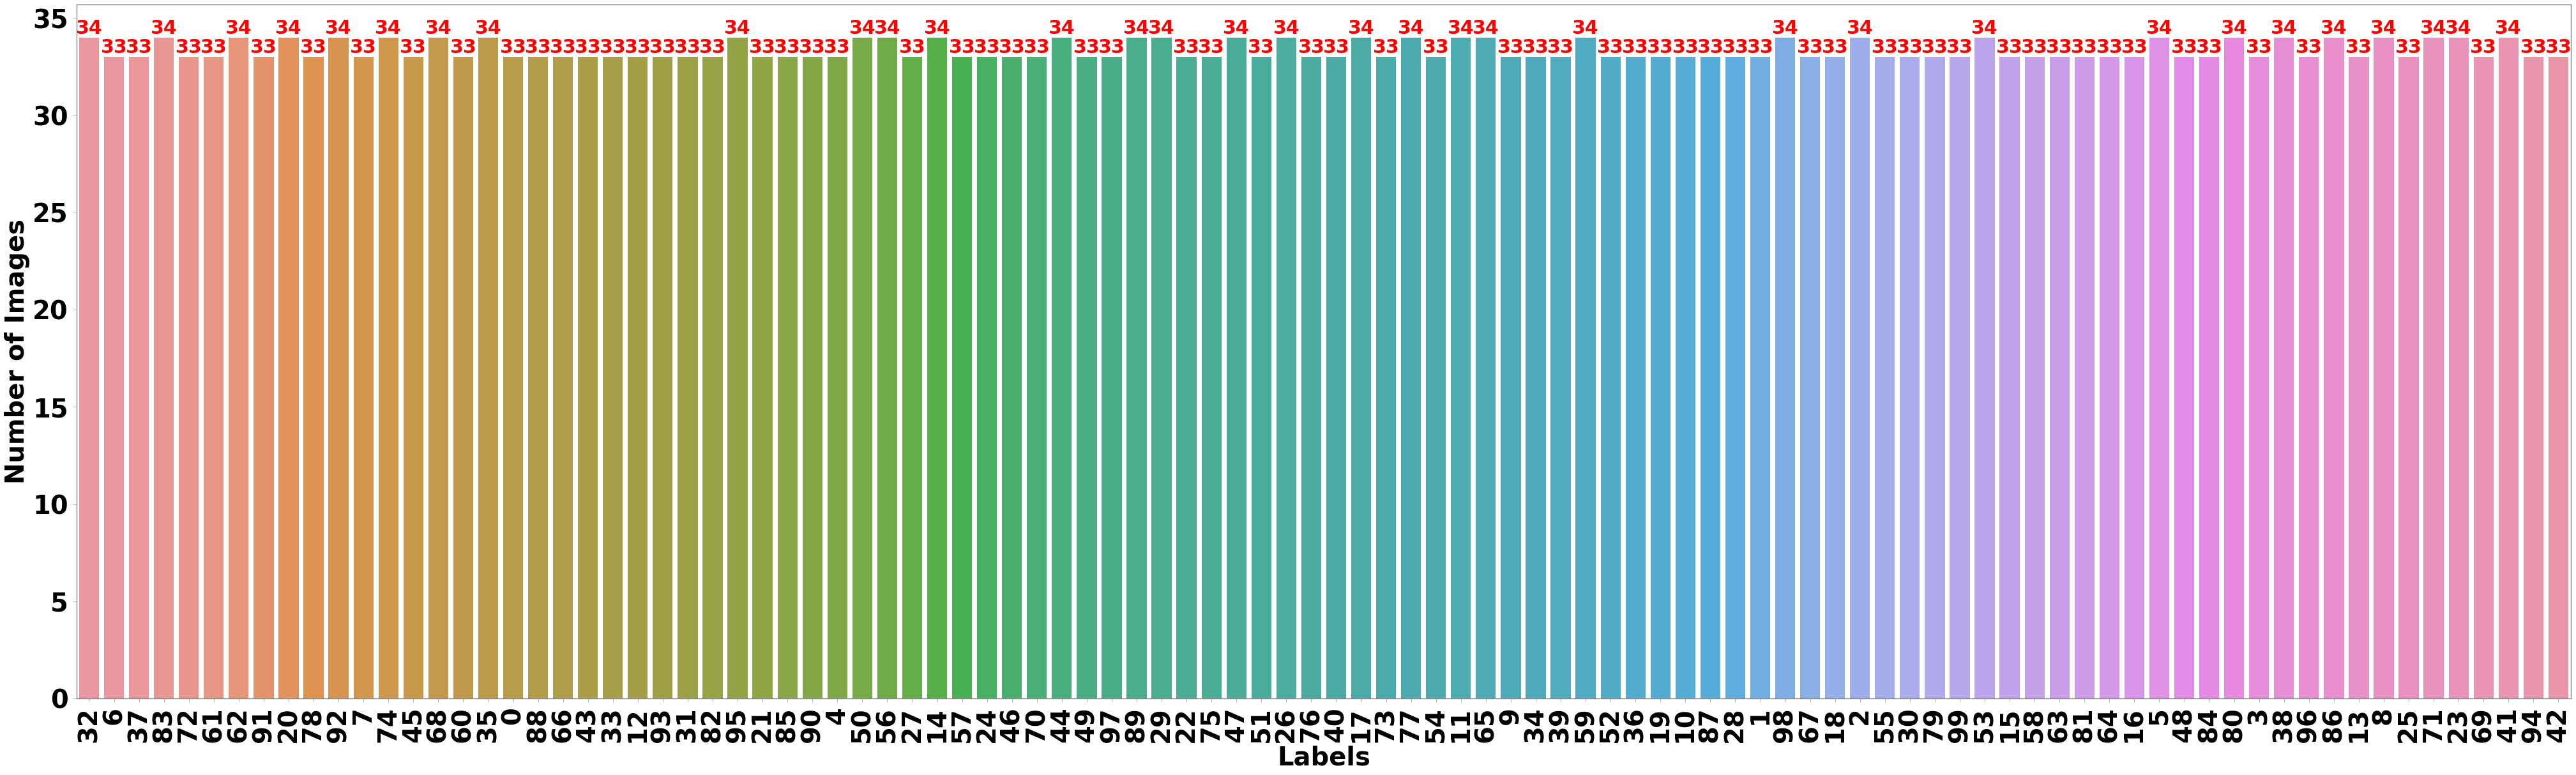

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [13]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [14]:
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


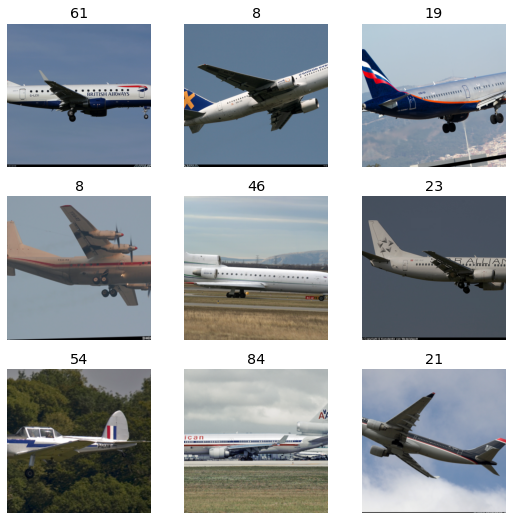

In [15]:
data0.show_batch()

In [16]:
import damped_losses as losses
loss_func = losses.DampedSCELossFlat(num_classes = num_classes, alpha = 0.1, beta = 1.0, delta=0.0,reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=num_classes)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [17]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= sce_aircrafts_sym_0.4_baseline


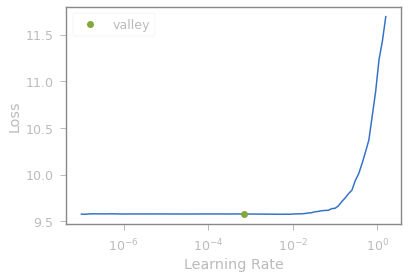

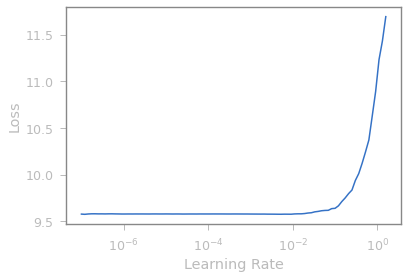

In [21]:
learn.lr_find()
learn.recorder.plot_lr_find()

Better model found at epoch 0 with accuracy value: 0.06301575154066086.


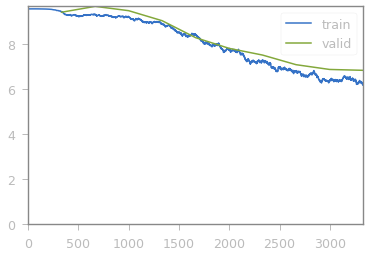

Better model found at epoch 2 with accuracy value: 0.06901725381612778.
Better model found at epoch 3 with accuracy value: 0.12153038382530212.
Better model found at epoch 4 with accuracy value: 0.207801952958107.
Better model found at epoch 5 with accuracy value: 0.27906978130340576.
Better model found at epoch 6 with accuracy value: 0.32408103346824646.
Better model found at epoch 7 with accuracy value: 0.37359338998794556.
Better model found at epoch 8 with accuracy value: 0.38859716057777405.
Better model found at epoch 9 with accuracy value: 0.39684921503067017.


In [22]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [23]:
learn.unfreeze()

Better model found at epoch 0 with accuracy value: 0.40360090136528015.


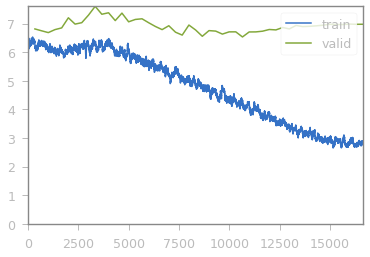

Better model found at epoch 1 with accuracy value: 0.42085522413253784.
Better model found at epoch 2 with accuracy value: 0.4238559603691101.
Better model found at epoch 21 with accuracy value: 0.4276069104671478.
Better model found at epoch 22 with accuracy value: 0.44486120343208313.
Better model found at epoch 25 with accuracy value: 0.45086270570755005.


In [24]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [25]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)
# inter_test0 = ClassificationInterpretation.from_learner(tester0, dl =data_test)
# inter_test0.plot_confusion_matrix(figsize = (50,60))

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.7129)


In [26]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.7249)


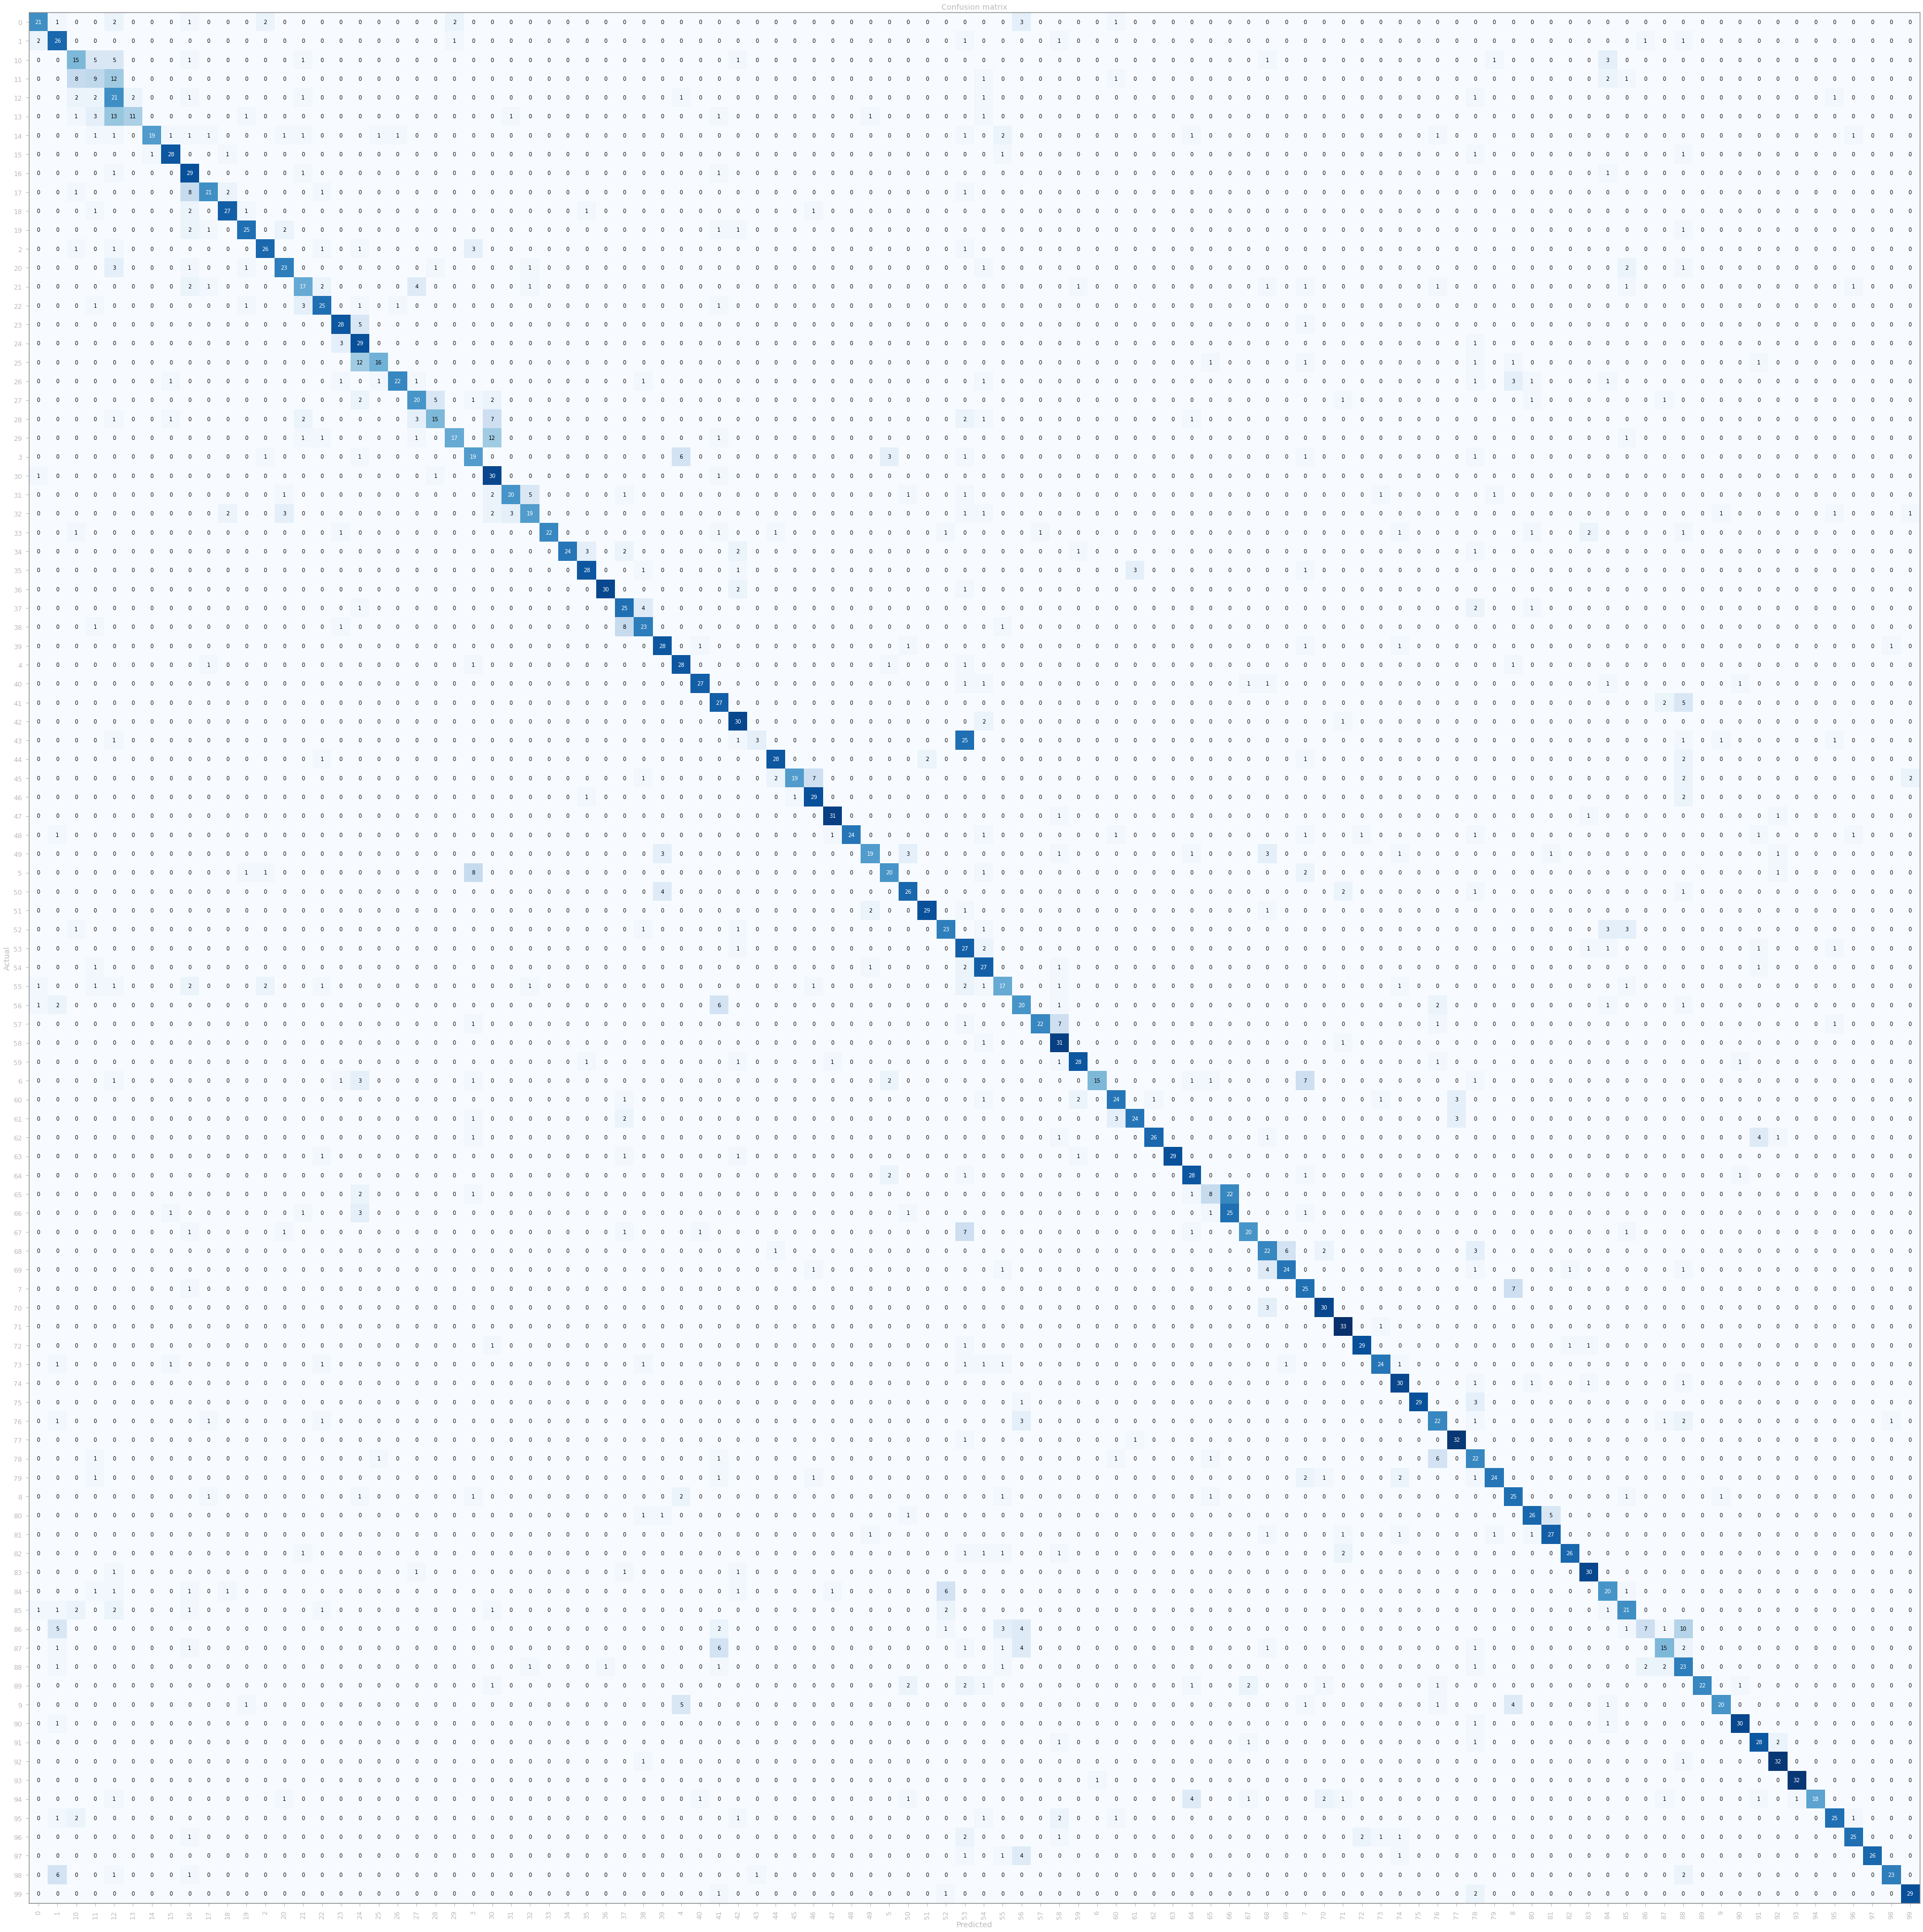

In [27]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [28]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [29]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/sce_aircrafts_sym_0.4_baseline.pth'

In [23]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples=k_samples, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 45 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6622


Better model found at epoch 0 with accuracy value: 0.5876132845878601.


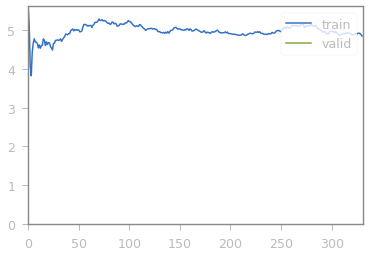

************Round:  0
TTA Accuracy:0.7644764184951782
cycle 0 Error Rate is [{0: (0.6749662516874144, 23.552358150482178)}]


+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 44 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6578


Better model found at epoch 0 with accuracy value: 0.6106463670730591.


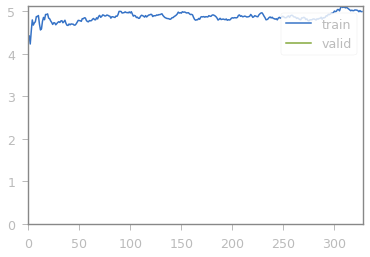

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 43 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6535


Better model found at epoch 0 with accuracy value: 0.6029074192047119.


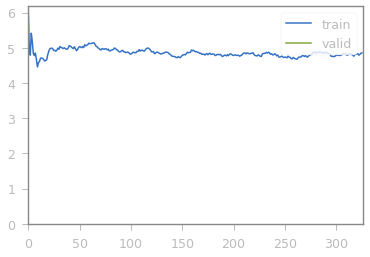

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 38 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6497


Better model found at epoch 0 with accuracy value: 0.5927636623382568.


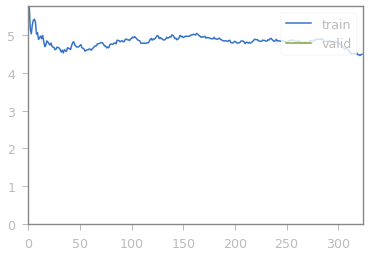

************Round:  3
TTA Accuracy:0.7854785323143005
cycle 0 Error Rate is [{0: (0.6749662516874144, 23.552358150482178), 3: (2.549872506374684, 21.452146768569946)}]


+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 37 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6460


Better model found at epoch 0 with accuracy value: 0.6253870129585266.


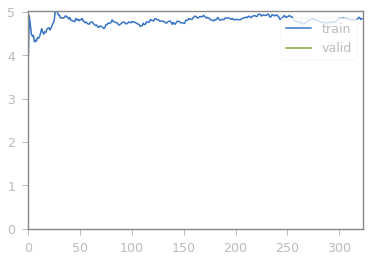

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 38 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6422


Better model found at epoch 0 with accuracy value: 0.6168224215507507.


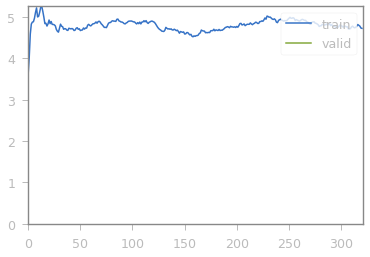

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 33 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6389


Better model found at epoch 0 with accuracy value: 0.6249021291732788.


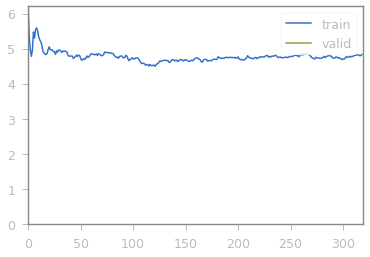

************Round:  6
TTA Accuracy:0.7950795292854309
cycle 0 Error Rate is [{0: (0.6749662516874144, 23.552358150482178), 3: (2.549872506374684, 21.452146768569946), 6: (4.169791510424481, 20.49204707145691)}]


+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 41 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6348


Better model found at epoch 0 with accuracy value: 0.6052009463310242.


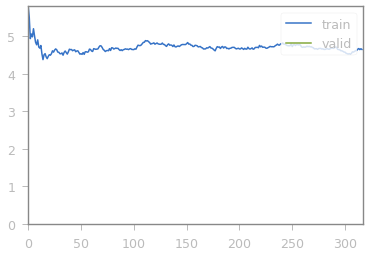

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 37 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6311


Better model found at epoch 0 with accuracy value: 0.6323296427726746.


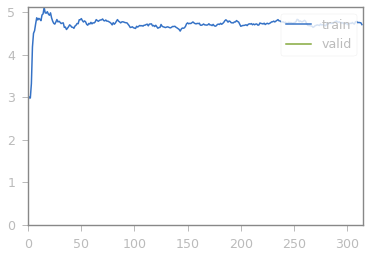

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 37 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6274


Better model found at epoch 0 with accuracy value: 0.6307814717292786.


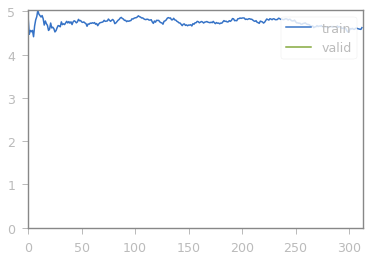

************Round:  9
TTA Accuracy:0.8013801574707031
cycle 0 Error Rate is [{0: (0.6749662516874144, 23.552358150482178), 3: (2.549872506374684, 21.452146768569946), 6: (4.169791510424481, 20.49204707145691), 9: (5.894705264736766, 19.861984252929688)}]


+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 29 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6245


Better model found at epoch 0 with accuracy value: 0.6172938346862793.


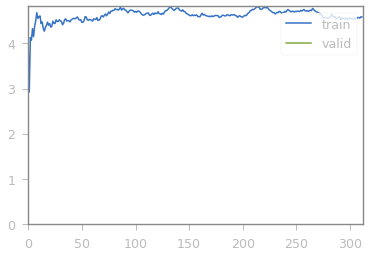

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 35 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6210


Better model found at epoch 0 with accuracy value: 0.6070853471755981.


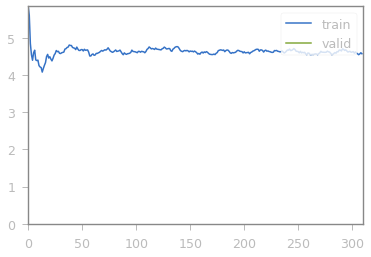

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 29 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6181


Better model found at epoch 0 with accuracy value: 0.598705530166626.


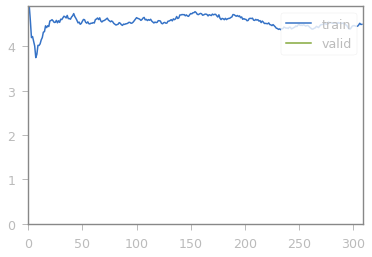

************Round:  12
TTA Accuracy:0.8010801076889038
cycle 0 Error Rate is [{0: (0.6749662516874144, 23.552358150482178), 3: (2.549872506374684, 21.452146768569946), 6: (4.169791510424481, 20.49204707145691), 9: (5.894705264736766, 19.861984252929688), 12: (7.289635518224092, 19.89198923110962)}]


+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 48
Min probability = 0.6447761194029851
Dropped 32 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6149


Better model found at epoch 0 with accuracy value: 0.6371033191680908.


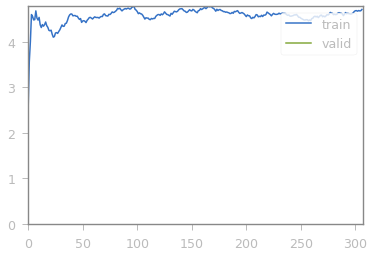

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 66
Min frequency is 48
Min probability = 0.6545454545454545
Dropped 33 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6116


Better model found at epoch 0 with accuracy value: 0.6107931137084961.


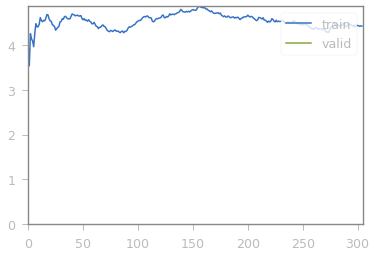

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 46 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6621


Better model found at epoch 0 with accuracy value: 0.6321752071380615.


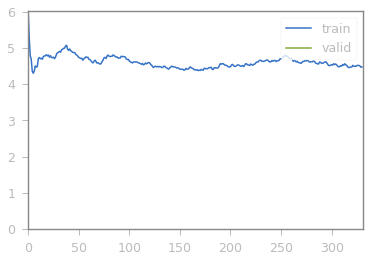

************Round:  0
TTA Accuracy:0.8022802472114563
cycle 1 Error Rate is [{0: (0.6749662516874144, 23.552358150482178), 3: (2.549872506374684, 21.452146768569946), 6: (4.169791510424481, 20.49204707145691), 9: (5.894705264736766, 19.861984252929688), 12: (7.289635518224092, 19.89198923110962), 15: (0.6899655017249096, 19.77197527885437)}]


+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 42 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6579


Better model found at epoch 0 with accuracy value: 0.6410646438598633.


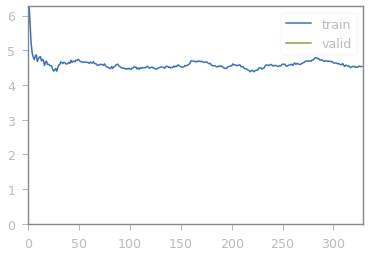

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 38 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6541


Better model found at epoch 0 with accuracy value: 0.641437292098999.


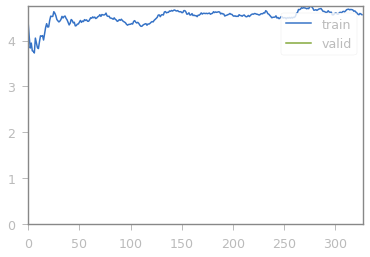

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 40 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6501


Better model found at epoch 0 with accuracy value: 0.6299999952316284.


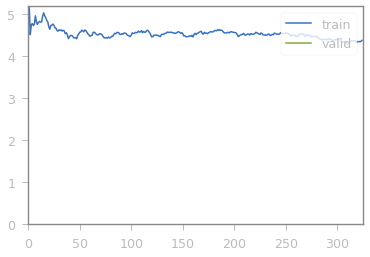

************Round:  3
TTA Accuracy:0.80048006772995
cycle 1 Error Rate is [{0: (0.6749662516874144, 23.552358150482178), 3: (2.549872506374684, 21.452146768569946), 6: (4.169791510424481, 20.49204707145691), 9: (5.894705264736766, 19.861984252929688), 12: (7.289635518224092, 19.89198923110962), 15: (0.6899655017249096, 19.77197527885437), 18: (2.4898755062246924, 19.951993227005005)}]


+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 40 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6461


Better model found at epoch 0 with accuracy value: 0.6369969248771667.


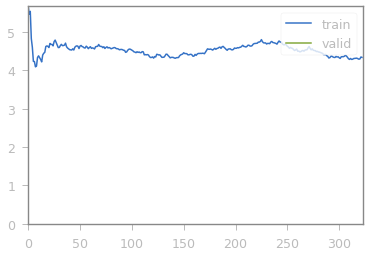

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 34 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6427


Better model found at epoch 0 with accuracy value: 0.6505836844444275.


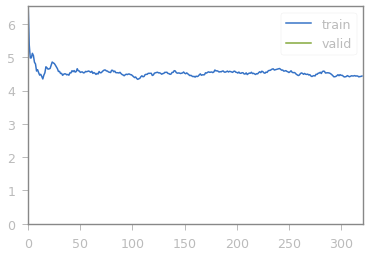

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 33 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6394


Better model found at epoch 0 with accuracy value: 0.6517996788024902.


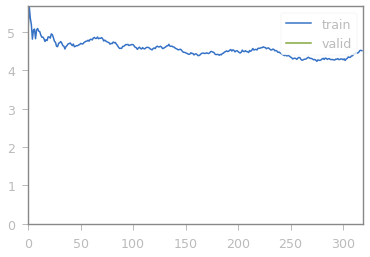

************Round:  6
TTA Accuracy:0.8028802871704102
cycle 1 Error Rate is [{0: (0.6749662516874144, 23.552358150482178), 3: (2.549872506374684, 21.452146768569946), 6: (4.169791510424481, 20.49204707145691), 9: (5.894705264736766, 19.861984252929688), 12: (7.289635518224092, 19.89198923110962), 15: (0.6899655017249096, 19.77197527885437), 18: (2.4898755062246924, 19.951993227005005), 21: (4.0947952602369835, 19.711971282958984)}]


+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 35 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6359


Better model found at epoch 0 with accuracy value: 0.6443744897842407.


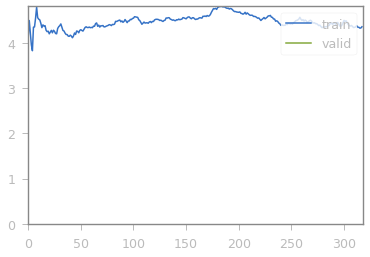

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 28 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6331


Better model found at epoch 0 with accuracy value: 0.640600323677063.


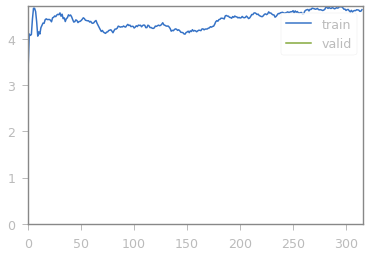

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 37 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6294


Better model found at epoch 0 with accuracy value: 0.6486486196517944.


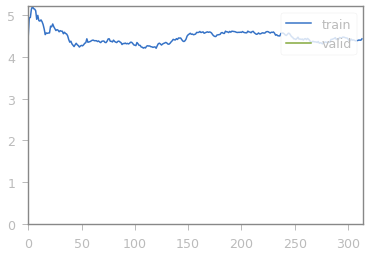

************Round:  9
TTA Accuracy:0.8028802871704102
cycle 1 Error Rate is [{0: (0.6749662516874144, 23.552358150482178), 3: (2.549872506374684, 21.452146768569946), 6: (4.169791510424481, 20.49204707145691), 9: (5.894705264736766, 19.861984252929688), 12: (7.289635518224092, 19.89198923110962), 15: (0.6899655017249096, 19.77197527885437), 18: (2.4898755062246924, 19.951993227005005), 21: (4.0947952602369835, 19.711971282958984), 24: (5.594720263986797, 19.711971282958984)}]


+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 31 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6263


Better model found at epoch 0 with accuracy value: 0.6365814805030823.


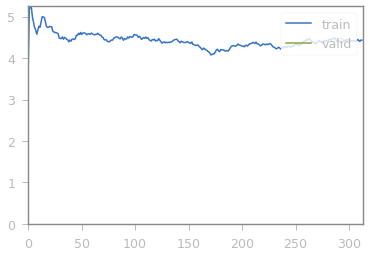

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 29 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6234


Better model found at epoch 0 with accuracy value: 0.646869957447052.


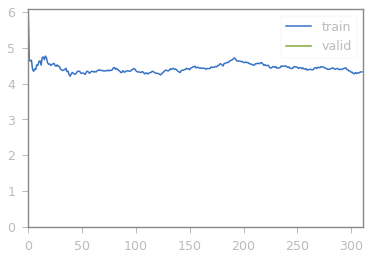

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 32 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6202


Better model found at epoch 0 with accuracy value: 0.6306451559066772.


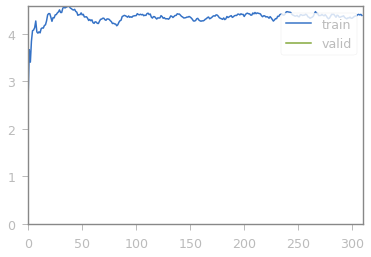

************Round:  12
TTA Accuracy:0.80048006772995
cycle 1 Error Rate is [{0: (0.6749662516874144, 23.552358150482178), 3: (2.549872506374684, 21.452146768569946), 6: (4.169791510424481, 20.49204707145691), 9: (5.894705264736766, 19.861984252929688), 12: (7.289635518224092, 19.89198923110962), 15: (0.6899655017249096, 19.77197527885437), 18: (2.4898755062246924, 19.951993227005005), 21: (4.0947952602369835, 19.711971282958984), 24: (5.594720263986797, 19.711971282958984), 27: (6.974651267436627, 19.951993227005005)}]


+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 31 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6171


Better model found at epoch 0 with accuracy value: 0.642625629901886.


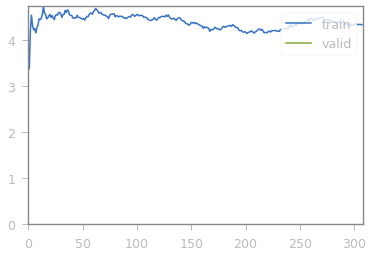

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 27 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6144


Better model found at epoch 0 with accuracy value: 0.638436496257782.


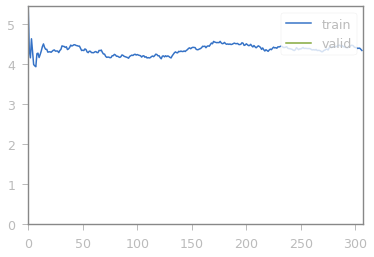

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 43 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6624


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.75 GiB total capacity; 9.06 GiB already allocated; 29.19 MiB free; 9.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

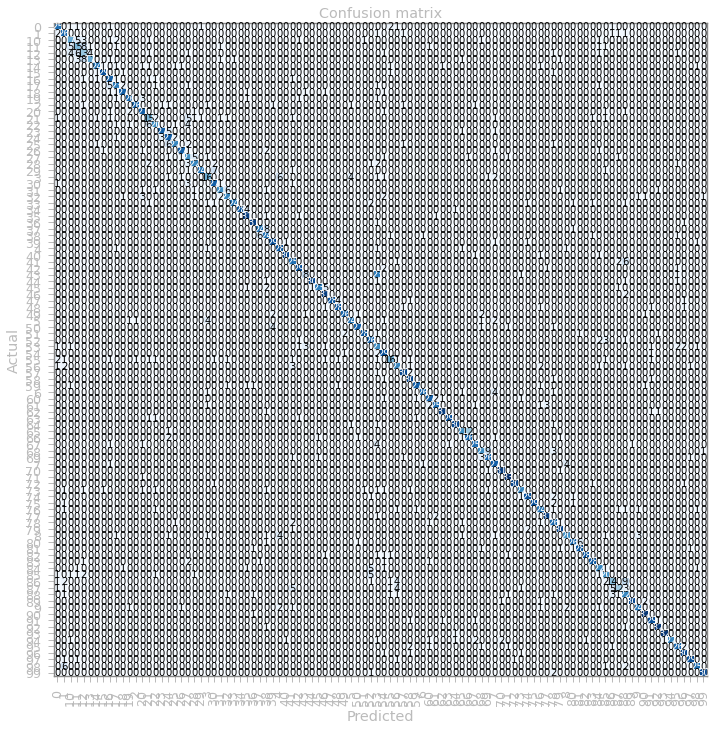

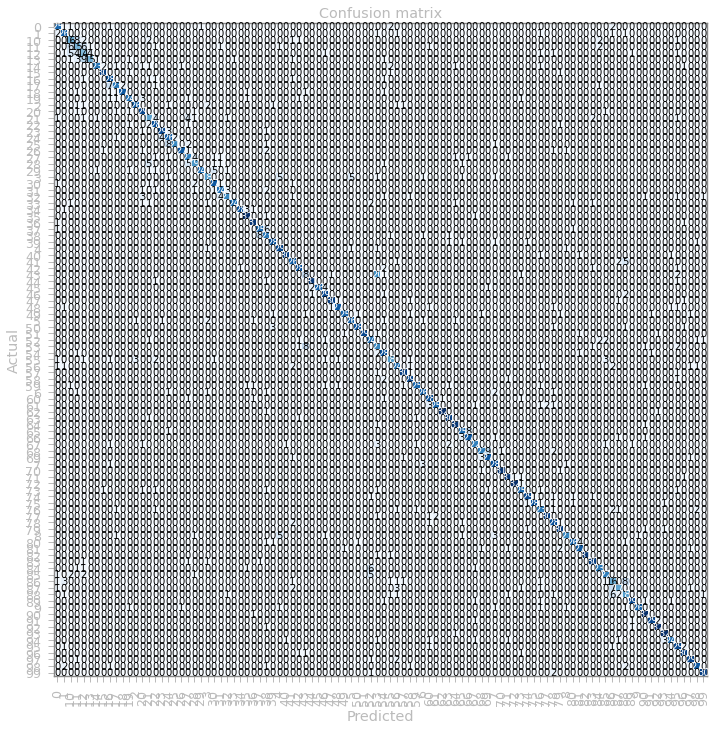

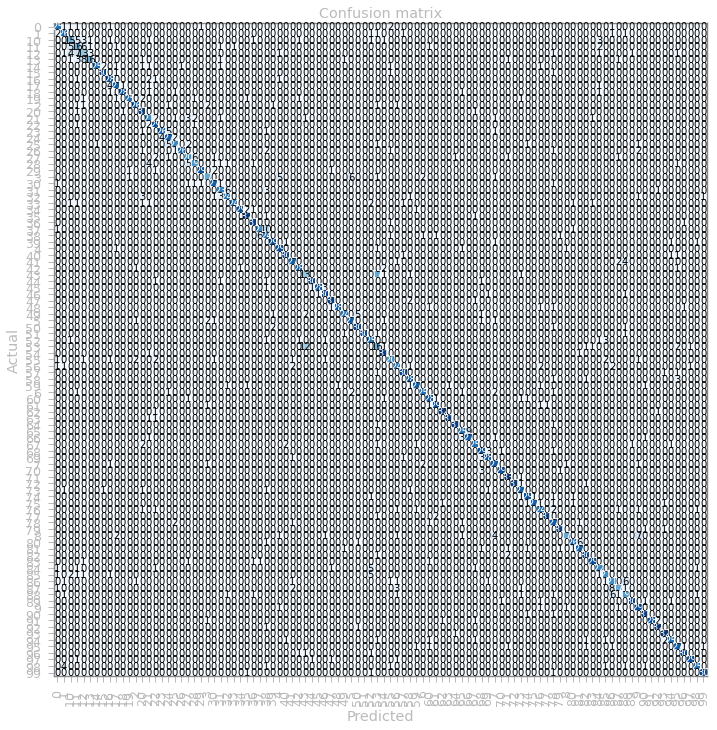

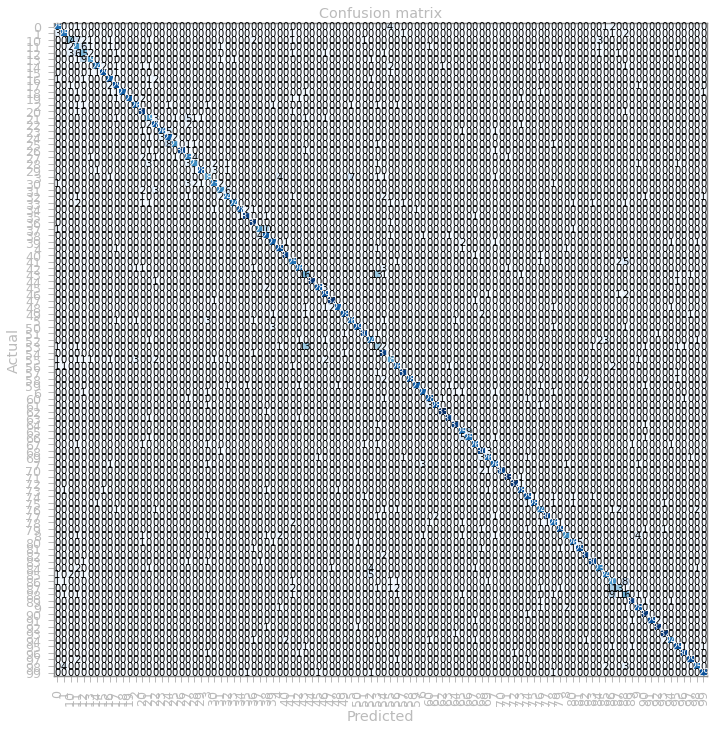

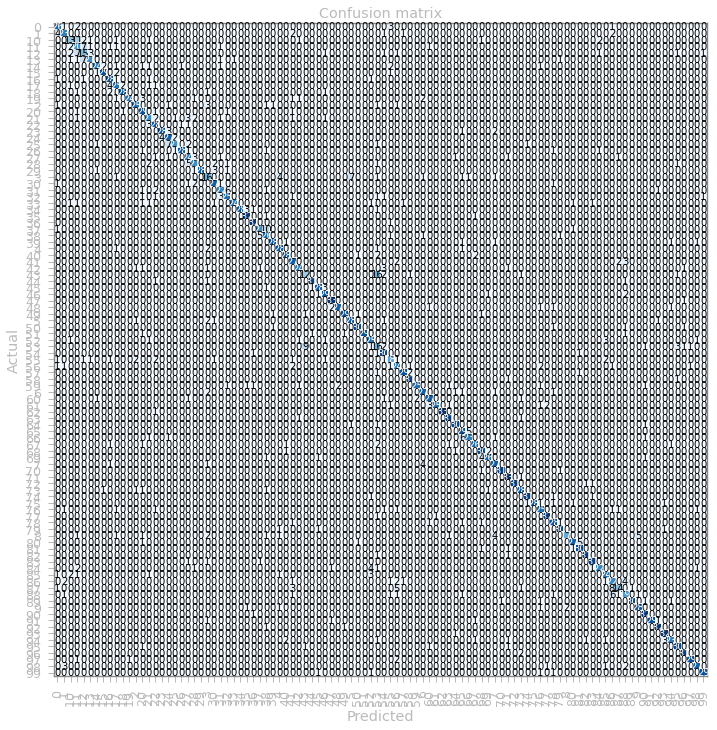

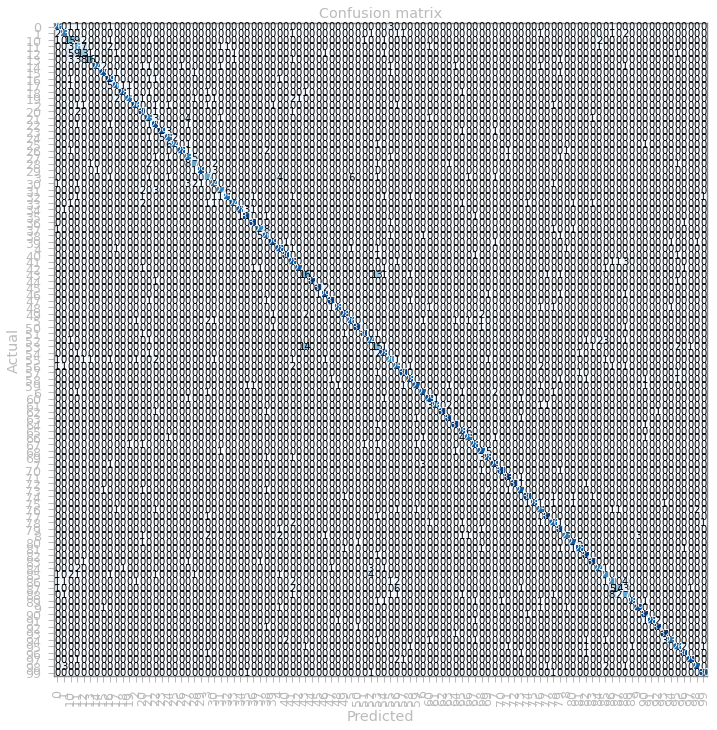

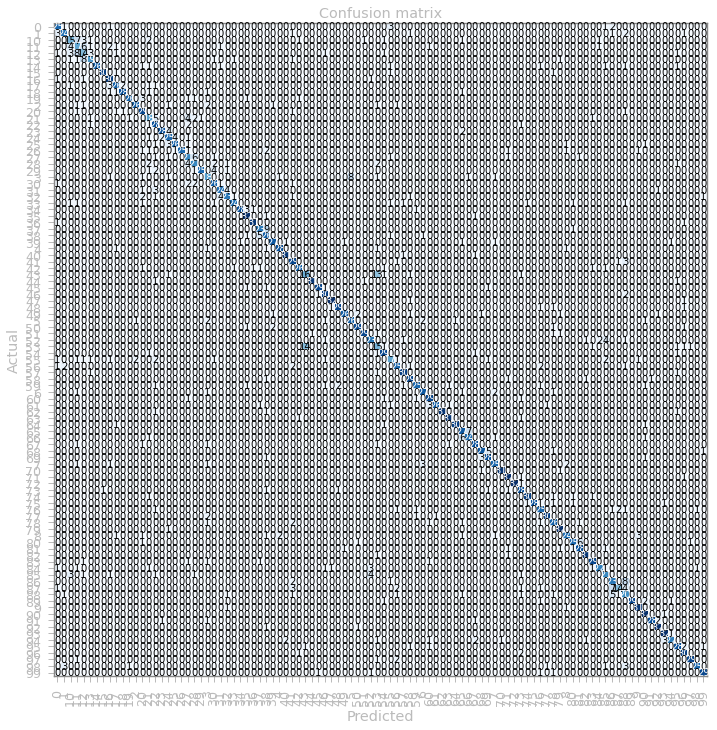

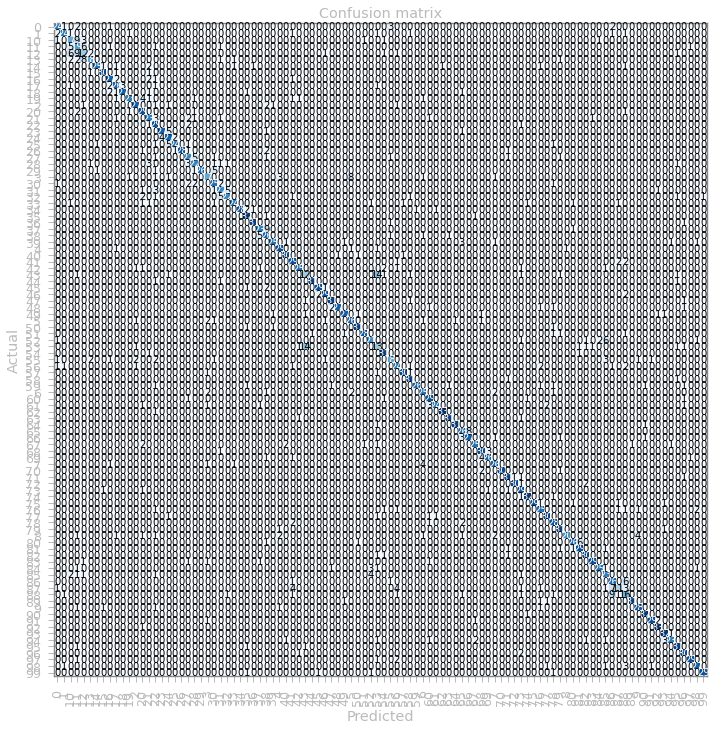

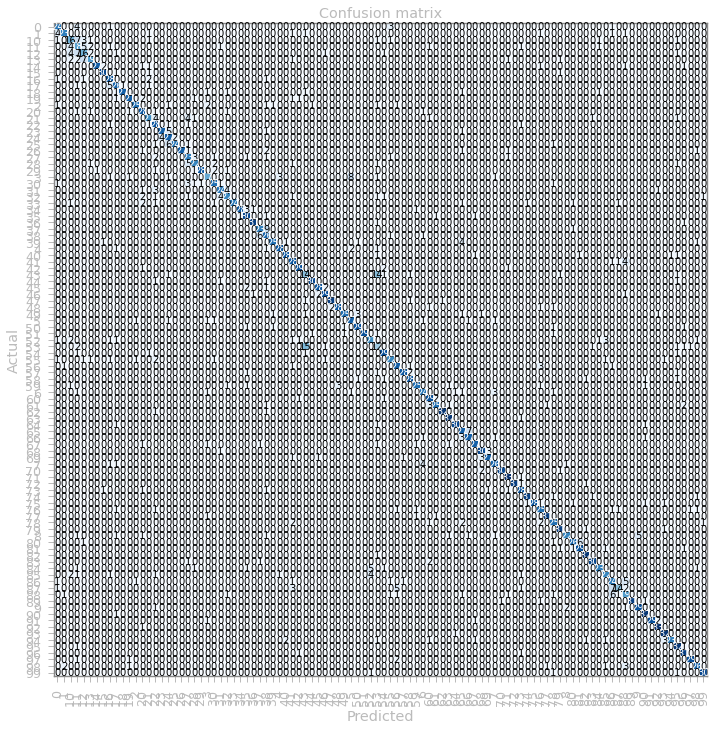

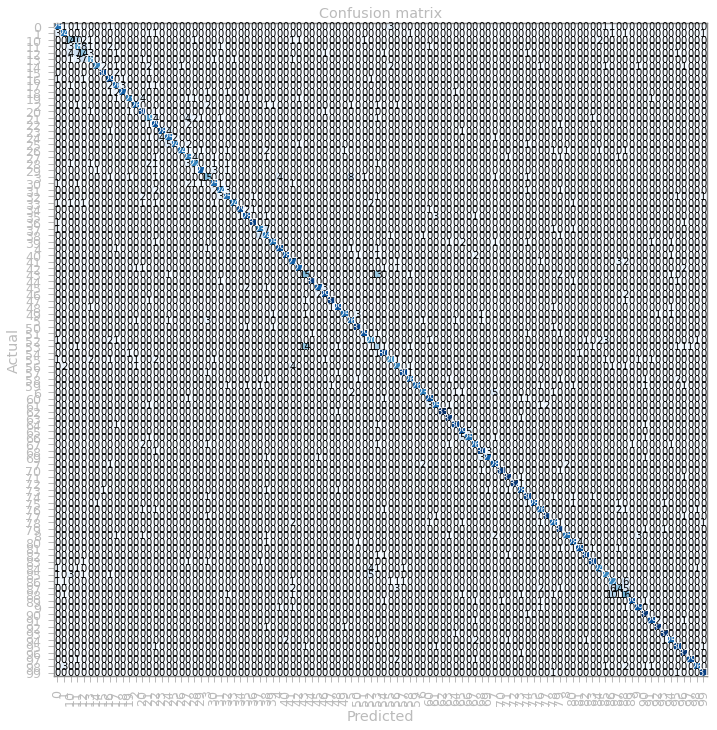

In [31]:
# Define required parameters and lists
n_training_series = 15  # Number of training series for scheme, means iteration in a single cycle
cleaning_cycles = 3   # Number of cleaning cycles for scheme
delta_max = 0.25       # Max delta value for scheme, damping factor value
min_epochs = 1         # number of loop in a single training of series 
min_lr = 1e-4          # for dynamic learning rates, if use.
kappa_lr = 1           # for dynamic learning rates, if use.
min_prob = 0.5         # probability of min classes.
max_prob = 0.9         # probability of max classes.
delta_epochs_per_serie = 0   # change in number of epochs
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
accs = []
deltas = []
err = {}


for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedSCELossFlat(num_classes = num_classes, alpha = 0.1, beta = 1.0, delta=delta,reduction='mean')     
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
            inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_1_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)         

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 42 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6625


Better model found at epoch 0 with accuracy value: 0.644528329372406.


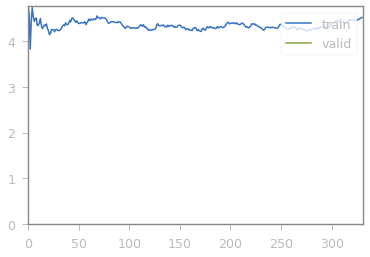

************Round:  0
TTA Accuracy:0.7959796190261841
cycle 0 Error Rate is [{0: (0.6299685015749179, 20.402038097381592)}]


+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 43 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6582


Better model found at epoch 0 with accuracy value: 0.630699098110199.


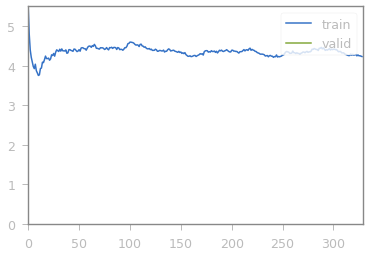

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 33 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6549


Better model found at epoch 0 with accuracy value: 0.6378915309906006.


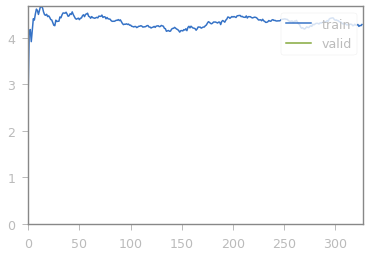

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 35 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6514


Better model found at epoch 0 with accuracy value: 0.6728110313415527.


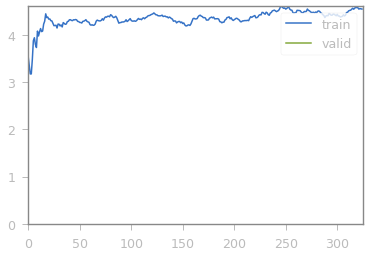

************Round:  3
TTA Accuracy:0.7953795194625854
cycle 0 Error Rate is [{0: (0.6299685015749179, 20.402038097381592), 3: (2.2948852557372112, 20.462048053741455)}]


+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 50
Min probability = 0.6716417910447762
Dropped 32 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6482


Better model found at epoch 0 with accuracy value: 0.6273148059844971.


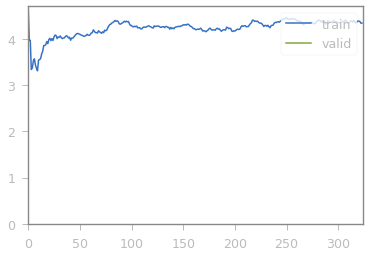

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 30 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6452


Better model found at epoch 0 with accuracy value: 0.6604651212692261.


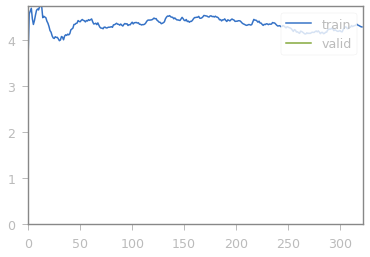

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 27 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6425


Better model found at epoch 0 with accuracy value: 0.6747081875801086.


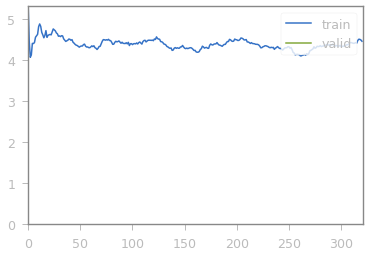

************Round:  6
TTA Accuracy:0.7947794795036316
cycle 0 Error Rate is [{0: (0.6299685015749179, 20.402038097381592), 3: (2.2948852557372112, 20.462048053741455), 6: (3.629818509074545, 20.52205204963684)}]


+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 27 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6398


Better model found at epoch 0 with accuracy value: 0.6591086983680725.


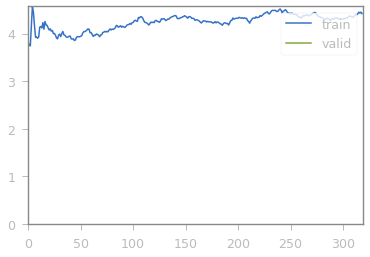

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 26 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6372


Better model found at epoch 0 with accuracy value: 0.6640502214431763.


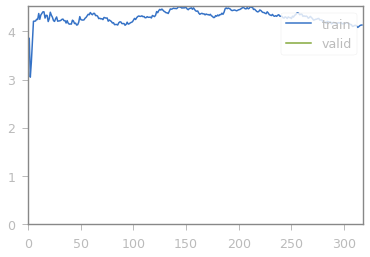

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 30 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6342


Better model found at epoch 0 with accuracy value: 0.6388012766838074.


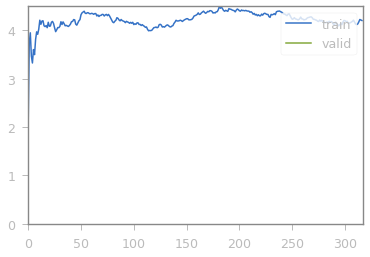

************Round:  9
TTA Accuracy:0.7959796190261841
cycle 0 Error Rate is [{0: (0.6299685015749179, 20.402038097381592), 3: (2.2948852557372112, 20.462048053741455), 6: (3.629818509074545, 20.52205204963684), 9: (4.874756262186885, 20.402038097381592)}]


+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 47
Min probability = 0.6313432835820896
Dropped 31 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6311


Better model found at epoch 0 with accuracy value: 0.670364499092102.


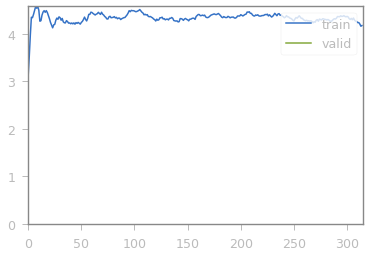

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 30 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6281


Better model found at epoch 0 with accuracy value: 0.6616241931915283.


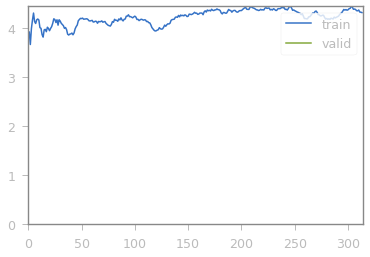

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 30 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6251


Better model found at epoch 0 with accuracy value: 0.6776000261306763.


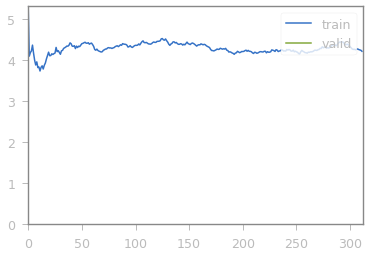

************Round:  12
TTA Accuracy:0.7923792600631714
cycle 0 Error Rate is [{0: (0.6299685015749179, 20.402038097381592), 3: (2.2948852557372112, 20.462048053741455), 6: (3.629818509074545, 20.52205204963684), 9: (4.874756262186885, 20.402038097381592), 12: (6.239688015599221, 20.76207399368286)}]


+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 23 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6228


Better model found at epoch 0 with accuracy value: 0.6618474125862122.


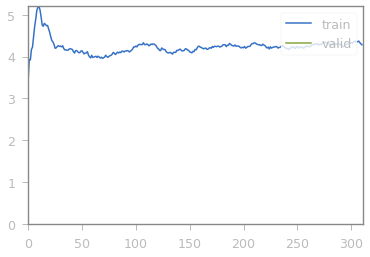

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 27 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6201


Better model found at epoch 0 with accuracy value: 0.6620967984199524.


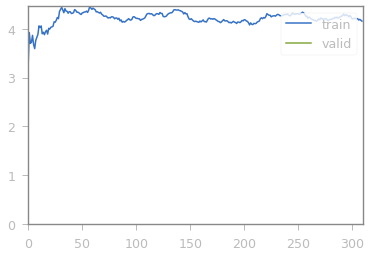

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 45 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6622


Better model found at epoch 0 with accuracy value: 0.6601208448410034.


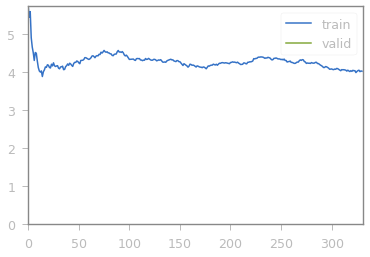

************Round:  0
TTA Accuracy:0.7923792600631714
cycle 1 Error Rate is [{0: (0.6299685015749179, 20.402038097381592), 3: (2.2948852557372112, 20.462048053741455), 6: (3.629818509074545, 20.52205204963684), 9: (4.874756262186885, 20.402038097381592), 12: (6.239688015599221, 20.76207399368286), 15: (0.6749662516874144, 20.76207399368286)}]


+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 37 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6585


Better model found at epoch 0 with accuracy value: 0.6545178294181824.


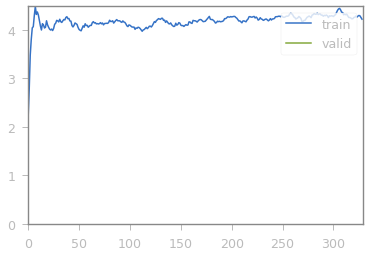

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 42 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6543


Better model found at epoch 0 with accuracy value: 0.6766055226325989.


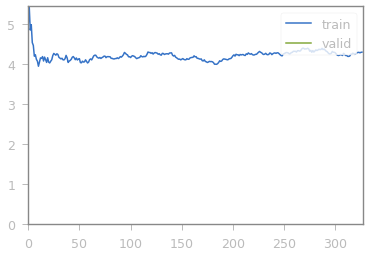

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 41 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6502


Better model found at epoch 0 with accuracy value: 0.6730769276618958.


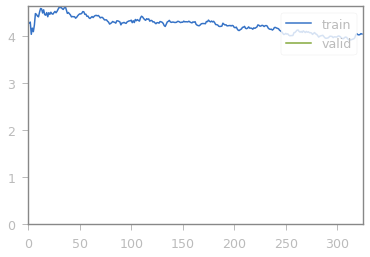

************Round:  3
TTA Accuracy:0.7857785820960999
cycle 1 Error Rate is [{0: (0.6299685015749179, 20.402038097381592), 3: (2.2948852557372112, 20.462048053741455), 6: (3.629818509074545, 20.52205204963684), 9: (4.874756262186885, 20.402038097381592), 12: (6.239688015599221, 20.76207399368286), 15: (0.6749662516874144, 20.76207399368286), 18: (2.474876256187186, 21.422141790390015)}]


+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 38 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6464


Better model found at epoch 0 with accuracy value: 0.6540247797966003.


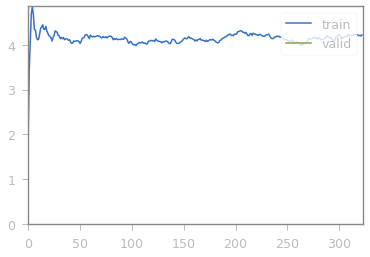

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 39 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6425


RuntimeError: CUDA out of memory. Tried to allocate 152.00 MiB (GPU 0; 10.75 GiB total capacity; 8.91 GiB already allocated; 161.19 MiB free; 9.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

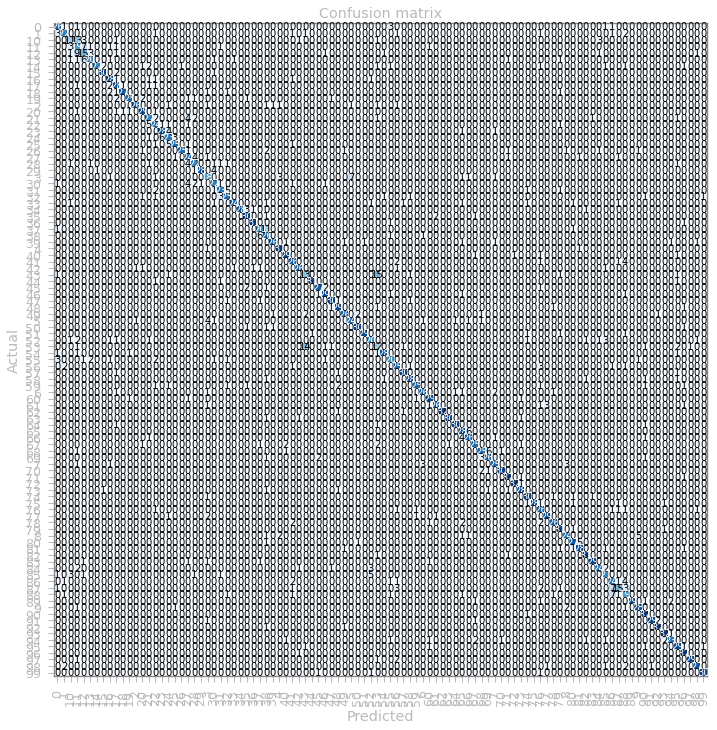

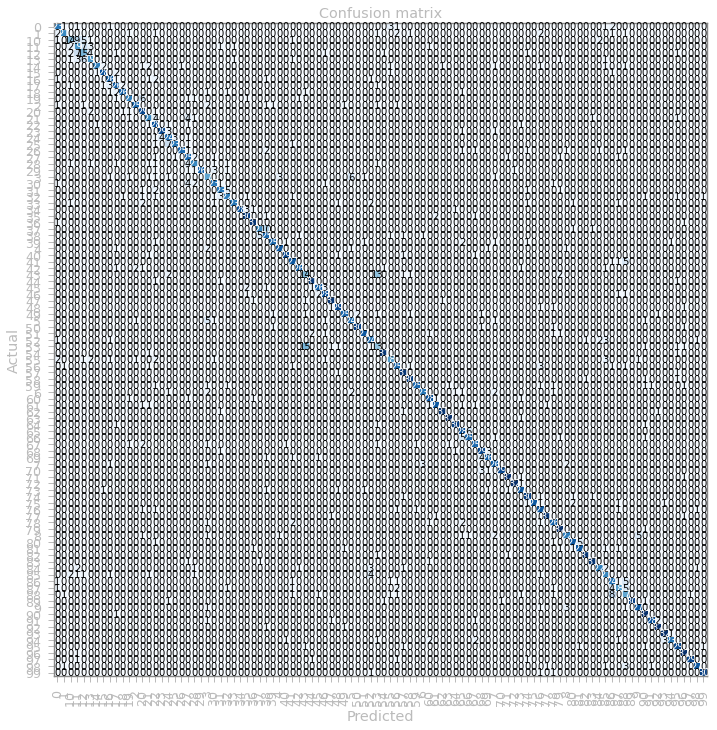

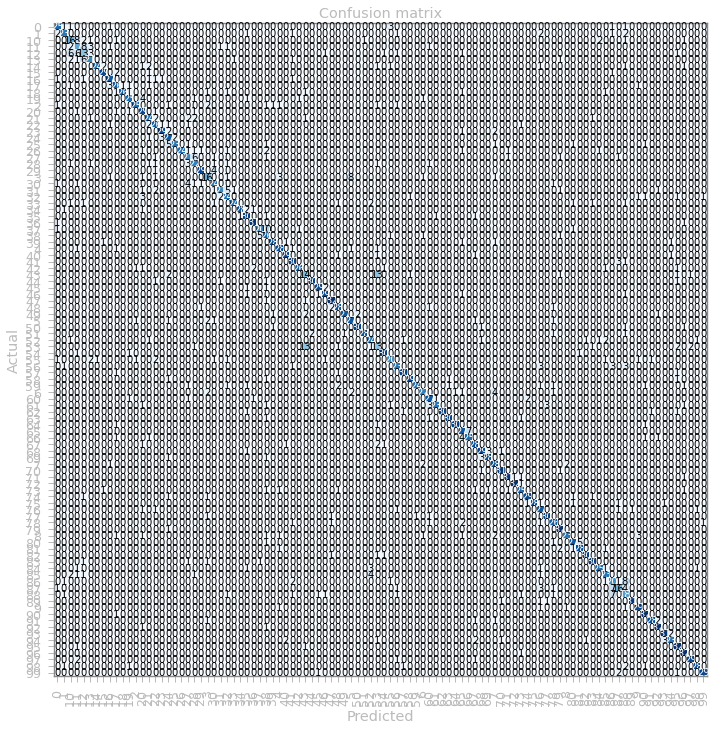

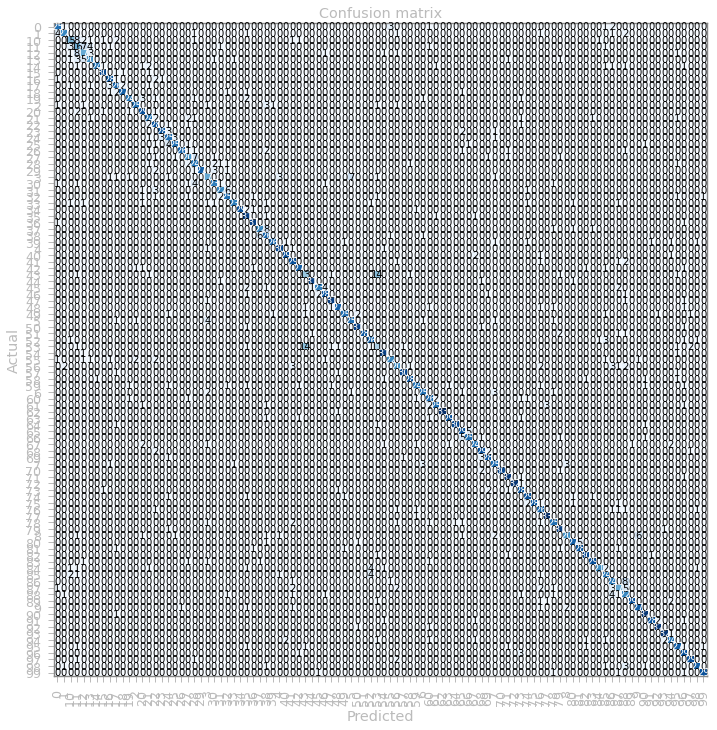

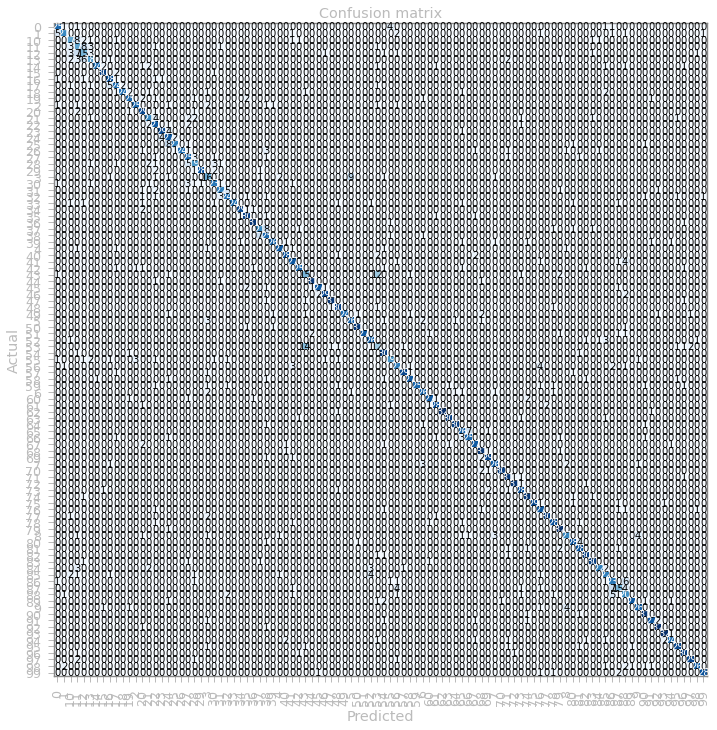

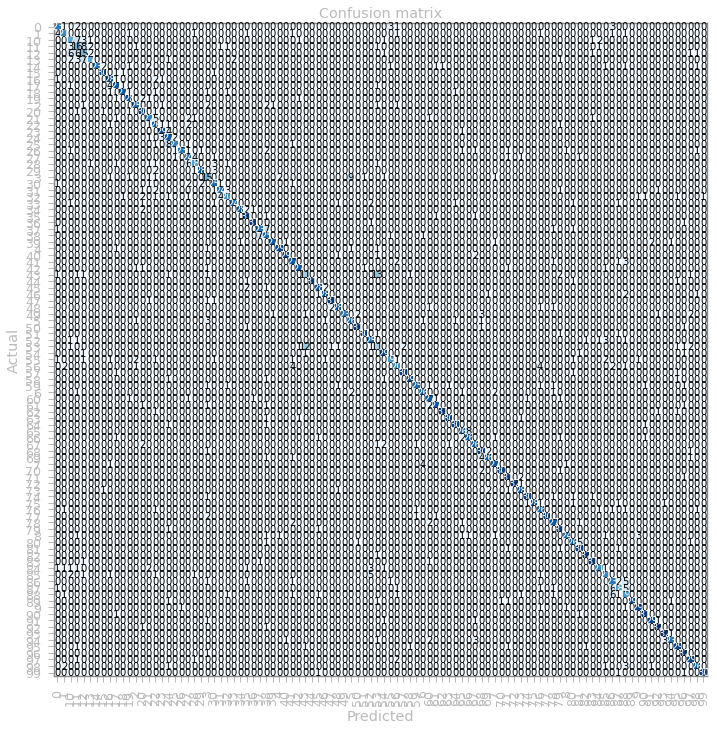

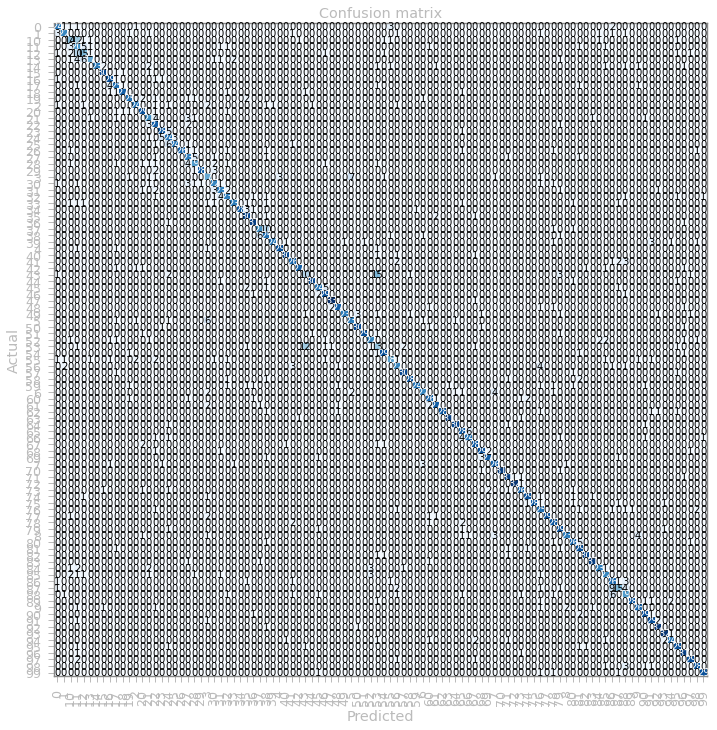

In [24]:
delta_max = 0.50
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedSCELossFlat(num_classes = num_classes, alpha = 0.1, beta = 1.0, delta=delta,reduction='mean')
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
            inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
